In [40]:
import tensorflow as tf

from data_loader.ISPRS_data_loader import ISPRSLoader
from models.fcn_base_model import FcnBaseModel
from trainers.aerial_image_trainer import AerialImageTrainer
# from models.unet_model import UNetModel
# from trainers.road_trainer import RoadTrainer

from utils.config import process_config
from utils.dirs import create_dirs
from utils.logger import Logger
from utils.utils import get_args
import matplotlib.pyplot as plt
import os 
from utils.visualize import *
import scipy.misc



json_file = "configs/fcn_ISPRS_Vaihingen_config.json"
json_file

config = process_config(json_file)
print(config)


colordict = {0:[255,0,0],
             1:[255,255,255],
             2:[0,0,255],
             3:[0,255,255],
             4:[0,255,0],
             5:[255,255,0]}

accuracy: sparse_categorical_crossentropy
batch_size: 5
checkpoint_dir: ./experiments\fcn_Vaihingen\checkpoint/
data_path: C:\Users\TT260256\My Project\NNs\ISPRS_benchmarks_datasets\Vaihingen\
exp_name: fcn_Vaihingen
final_model_dir: ./experiments\fcn_Vaihingen\saved_model/
image_size:
- 256
- 256
- 3
images_dir: ./experiments\fcn_Vaihingen\images/
learning_rate: 0.00023949513325777832
loss: scce
max_to_keep: 5
n_classes: 3
num_epochs: 45
num_iter_per_epoch: 1000
summary_dir: ./experiments\fcn_Vaihingen\summary/



In [2]:
test_path = "C:\\Users\\TT260256\\My Project\\NNs\\ISPRS_benchmarks_datasets\\Vaihingen\\top\\top_mosaic_09cm_area4.tif"
test_path

'C:\\Users\\TT260256\\My Project\\NNs\\ISPRS_benchmarks_datasets\\Vaihingen\\top\\top_mosaic_09cm_area4.tif'

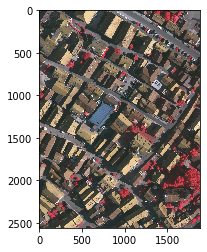

(2557, 1887, 3)


In [3]:
from PIL import Image
import numpy as np

test_image = np.array(Image.open(test_path))
plt.imshow(test_image)
plt.show()
print(test_image.shape)

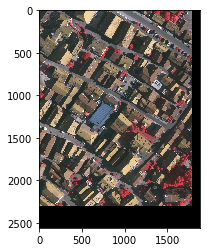

In [83]:
from utils.image_processing import *
test_img_list = split_image(test_image,[256,256])
norm_test_image = merge_image(test_image,test_img_list,[256,256])
plt.imshow(norm_test_image/255.0)
plt.show()

In [47]:
test_img_list = np.array(split_image(test_image,[256,256])).astype(np.float32)/255.0
print(test_img_list[0].shape)
print(test_img_list.shape)

(256, 256, 3)
(63, 256, 256, 3)


In [2]:
# data = ISPRSLoader(config)

INFO:tensorflow:Restoring parameters from ./experiments\fcn_Vaihingen\saved_model/variables\variables
0.294601


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


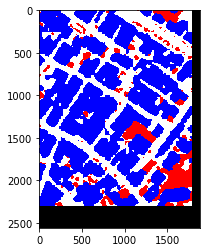

In [59]:
tf.reset_default_graph()
import numpy as np
import scipy
graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:   
        tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.TRAINING], config.final_model_dir)    
        bl = sess.run("best_loss/best_loss:0")
        print(bl)        
#         for op in graph.get_operations():
#             print(op.name)
            
        X_test = graph.get_tensor_by_name("inputs/X:0")
        y_test = graph.get_tensor_by_name("inputs/y:0")
        pred =  graph.get_tensor_by_name("eval/pred:0")
        
        y_test_flatten = tf.reshape(y_test,(-1,256*256))
        pred_flatten = tf.reshape(pred,(-1,256*256))
        
        mean_iou,conf_mat = tf.metrics.mean_iou(y_test_flatten,pred_flatten,config.n_classes)
        sess.run(tf.local_variables_initializer())
        
#         iou_list = []
        pred_img_list =[]
        for idx,img in enumerate(test_img_list) :
            out_pred = sess.run(pred,feed_dict={X_test : [img]})
#             plt.subplot(141)
#             plt.imshow(img)
#             plt.subplot(142)
#             plt.imshow(mask)
#             plt.subplot(143)
#             plt.imshow(out_pred[0])
#             plt.subplot(144)
#             out = visualize_output(img,out_pred[0],colordict)
#             plt.imshow(grayscale_to_colour(out_pred[0],colordict))
#             plt.show()
            pred_img_list.append(grayscale_to_colour(out_pred[0],colordict))
#             save_output(out, config.images_dir + "out{}.tif".format(idx))
#             sess.run([conf_mat],feed_dict={X_test:[img],y_test:[mask]})
#             iou_list.append(sess.run(mean_iou,feed_dict={X_test:[img],y_test:[mask]}))
        
#         print("mean IoU :" ,sess.run(tf.reduce_mean(iou_list)))
        pred_image = merge_image(test_image,pred_img_list,[256,256])
        plt.imshow(pred_image)
        plt.show()

In [72]:
pred_img = np.array(pred_image).astype(np.uint8)
print(pred_img.dtype)
print(pred_img.shape)
im = Image.fromarray(pred_img)
im.save(config.images_dir + "pred_mosaic_09cm_area4.tif")

uint8
(2557, 1887, 3)


In [84]:
original_img  = Image.fromarray(np.array(norm_test_image).astype(np.uint8))
original_img.show()

In [78]:
im.show()